<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/All_Cut_Leaw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [21]:
import pandas as pd
import shutil

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
df = pd.read_csv (r'/content/drive/My Drive/cut_panoramic/All_file_complete.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Filename,Path_filename,Sex,Floder
0,1.0,1,7,Y7F,V1.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
1,2.0,1,7,Y7F,Flip_V1.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
2,3.0,2,7,Y7F,V2.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
3,4.0,2,7,Y7F,Flip_V2.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
4,5.0,3,7,Y7F,V3.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
...,...,...,...,...,...,...,...,...
5472,215.0,50,25,Y25M,J146.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
5473,216.0,51,25,Y25M,J166.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
5474,217.0,52,25,Y25M,J169.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
5475,218.0,53,25,Y25M,J183.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt


##ขาดอายุ 14

In [25]:
classes = ['Y7F','Y7M','Y8F','Y8M','Y9F','Y9M','Y10F','Y10M','Y11F','Y11M','Y12F','Y12M','Y13F','Y13M','15F','15M','Y16F','Y16M','Y17F','Y17M','Y18F','Y18M','Y19F','Y19M','Y20F','Y20M','Y21F','Y21M','Y22F','Y22M','Y23F','Y23M','Y24F','Y24M','Y25F','Y25M']
len(classes)

36

In [26]:
df.shape

(5477, 8)

In [27]:
print(set(df['Class']))
print(set(df['Sex']))
print(set(df['Floder']))

{'Y16M', 'Y23M', 'Y10M', 'Y18F', 'Y11M', 'Y25M', 'Y17F', 'Y19F', 'Y13F', 'Y9F', 'Y10F', 'Y22F', 'Y11F', 'Y18M', 'Y22M', 'Y15F', 'Y20M', 'Y24M', 'Y21M', 'Y19M', 'Y8M', 'Y16F', 'Y15M', 'Y13M', 'Y17M', 'Y12F', 'Y7M', 'Y23F', 'Y21F', 'Y12M', 'Y20F', 'Y7F', 'Y24F', 'Y8F', 'Y25F', 'Y9M'}
{'เพศหญิง', 'เพศชาย'}
{'Rt', 'Both', 'Lt'}


#Imports

In [28]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#กำหนดค่าพารามิเตอร์


In [29]:
batch_size = 50
width = 150
height = 150
epochs = 20
NUM_TRAIN = 1800
NUM_TEST = 200
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [30]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
/content/efficientnet_keras_transfer_learning


In [31]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [32]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [33]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_65 (Conv2D)             (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_49 (BatchN  (None, 75, 75, 32)  128         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                    

#สร้างโฟลเดอร์ Train Valodation และ Test

In [34]:
base_dir = '/content/drive/My Drive/Trian_Validation_Test'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

##สร้างโฟลเดอร์ Train ของแต่ละอายุและแบ่งเป็นเพศหญิงและเพศชาย

In [35]:
train_Y7F_dir = os.path.join(train_dir, 'Y7F')
os.makedirs(train_Y7F_dir, exist_ok=True)
train_Y7M_dir = os.path.join(train_dir, 'Y7M')
os.makedirs(train_Y7M_dir, exist_ok=True)

train_Y8F_dir = os.path.join(train_dir, 'Y8F')
os.makedirs(train_Y8F_dir, exist_ok=True)
train_Y8M_dir = os.path.join(train_dir, 'Y8M')
os.makedirs(train_Y8M_dir, exist_ok=True)

train_Y9F_dir = os.path.join(train_dir, 'Y9F')
os.makedirs(train_Y9F_dir, exist_ok=True)
train_Y9M_dir = os.path.join(train_dir, 'Y9M')
os.makedirs(train_Y9M_dir, exist_ok=True)

train_Y10F_dir = os.path.join(train_dir, 'Y10F')
os.makedirs(train_Y10F_dir, exist_ok=True)
train_Y10M_dir = os.path.join(train_dir, 'Y10M')
os.makedirs(train_Y10M_dir, exist_ok=True)

train_Y11F_dir = os.path.join(train_dir, 'Y11F')
os.makedirs(train_Y11F_dir, exist_ok=True)
train_Y11M_dir = os.path.join(train_dir, 'Y11M')
os.makedirs(train_Y11M_dir, exist_ok=True)

train_Y12F_dir = os.path.join(train_dir, 'Y12')
os.makedirs(train_Y12F_dir, exist_ok=True)
train_Y12M_dir = os.path.join(train_dir, 'Y12')
os.makedirs(train_Y12M_dir, exist_ok=True)

train_Y13F_dir = os.path.join(train_dir, 'Y13F')
os.makedirs(train_Y13F_dir, exist_ok=True)
train_Y13M_dir = os.path.join(train_dir, 'Y13M')
os.makedirs(train_Y13M_dir, exist_ok=True)

# train_Y13_dir = os.path.join(train_dir, 'Y14F')
# os.makedirs(train_Y13_dir, exist_ok=True)
# train_Y13_dir = os.path.join(train_dir, 'Y14M')
# os.makedirs(train_Y13_dir, exist_ok=True)

train_Y15F_dir = os.path.join(train_dir, 'Y15F')
os.makedirs(train_Y15F_dir, exist_ok=True)
train_Y15M_dir = os.path.join(train_dir, 'Y15M')
os.makedirs(train_Y15M_dir, exist_ok=True)

train_Y16F_dir = os.path.join(train_dir, 'Y16F')
os.makedirs(train_Y16F_dir, exist_ok=True)
train_Y16M_dir = os.path.join(train_dir, 'Y16M')
os.makedirs(train_Y16M_dir, exist_ok=True)

train_Y17F_dir = os.path.join(train_dir, 'Y17F')
os.makedirs(train_Y17F_dir, exist_ok=True)
train_Y17M_dir = os.path.join(train_dir, 'Y17M')
os.makedirs(train_Y17M_dir, exist_ok=True)

train_Y18F_dir = os.path.join(train_dir, 'Y18F')
os.makedirs(train_Y18F_dir, exist_ok=True)
train_Y18M_dir = os.path.join(train_dir, 'Y18M')
os.makedirs(train_Y18M_dir, exist_ok=True)

train_Y19F_dir = os.path.join(train_dir, 'Y19F')
os.makedirs(train_Y19F_dir, exist_ok=True)
train_Y19M_dir = os.path.join(train_dir, 'Y19M')
os.makedirs(train_Y19M_dir, exist_ok=True)

train_Y20F_dir = os.path.join(train_dir, 'Y20F')
os.makedirs(train_Y20F_dir, exist_ok=True)
train_Y20M_dir = os.path.join(train_dir, 'Y20M')
os.makedirs(train_Y20M_dir, exist_ok=True)

train_Y21F_dir = os.path.join(train_dir, 'Y21F')
os.makedirs(train_Y21F_dir, exist_ok=True)
train_Y21M_dir = os.path.join(train_dir, 'Y21M')
os.makedirs(train_Y21M_dir, exist_ok=True)

train_Y22F_dir = os.path.join(train_dir, 'Y22F')
os.makedirs(train_Y22F_dir, exist_ok=True)
train_Y22M_dir = os.path.join(train_dir, 'Y22M')
os.makedirs(train_Y22M_dir, exist_ok=True)

train_Y23F_dir = os.path.join(train_dir, 'Y23F')
os.makedirs(train_Y23F_dir, exist_ok=True)
train_Y23M_dir = os.path.join(train_dir, 'Y23M')
os.makedirs(train_Y23M_dir, exist_ok=True)

train_Y24F_dir = os.path.join(train_dir, 'Y24F')
os.makedirs(train_Y24F_dir, exist_ok=True)
train_Y24M_dir = os.path.join(train_dir, 'Y24M')
os.makedirs(train_Y24M_dir, exist_ok=True)

train_Y25F_dir = os.path.join(train_dir, 'Y25F')
os.makedirs(train_Y25F_dir, exist_ok=True)
train_Y25M_dir = os.path.join(train_dir, 'Y25M')
os.makedirs(train_Y25M_dir, exist_ok=True)

##สร้างโฟลเดอร์ Validation ของแต่ละอายุและแบ่งเป็นเพศหญิงและเพศชาย

In [36]:
validation_Y7F_dir = os.path.join(validation_dir, 'Y7F')
os.makedirs(validation_Y7F_dir, exist_ok=True)
validation_Y7M_dir = os.path.join(validation_dir, 'Y7M')
os.makedirs(validation_Y7M_dir, exist_ok=True)

validation_Y8F_dir = os.path.join(validation_dir, 'Y8F')
os.makedirs(validation_Y8F_dir, exist_ok=True)
validation_Y8M_dir = os.path.join(validation_dir, 'Y8M')
os.makedirs(validation_Y8M_dir, exist_ok=True)

validation_Y9F_dir = os.path.join(validation_dir, 'Y9F')
os.makedirs(validation_Y9F_dir, exist_ok=True)
validation_Y9M_dir = os.path.join(validation_dir, 'Y9M')
os.makedirs(validation_Y9M_dir, exist_ok=True)

validation_Y10F_dir = os.path.join(validation_dir, 'Y10F')
os.makedirs(validation_Y10F_dir, exist_ok=True)
validation_Y10M_dir = os.path.join(validation_dir, 'Y10M')
os.makedirs(validation_Y10M_dir, exist_ok=True)

validation_Y11F_dir = os.path.join(validation_dir, 'Y11F')
os.makedirs(validation_Y11F_dir, exist_ok=True)
validation_Y11M_dir = os.path.join(validation_dir, 'Y11M')
os.makedirs(validation_Y11M_dir, exist_ok=True)

validation_Y12F_dir = os.path.join(validation_dir, 'Y12')
os.makedirs(validation_Y12F_dir, exist_ok=True)
validation_Y12M_dir = os.path.join(validation_dir, 'Y12')
os.makedirs(validation_Y12M_dir, exist_ok=True)

validation_Y13F_dir = os.path.join(validation_dir, 'Y13F')
os.makedirs(validation_Y13F_dir, exist_ok=True)
validation_Y13M_dir = os.path.join(validation_dir, 'Y13M')
os.makedirs(validation_Y13M_dir, exist_ok=True)

# validation_Y13_dir = os.path.join(validation_dir, 'Y14F')
# os.makedirs(validation_Y13_dir, exist_ok=True)
# validation_Y13_dir = os.path.join(validation_dir, 'Y14M')
# os.makedirs(validation_Y13_dir, exist_ok=True)

validation_Y15F_dir = os.path.join(validation_dir, 'Y15F')
os.makedirs(validation_Y15F_dir, exist_ok=True)
validation_Y15M_dir = os.path.join(validation_dir, 'Y15M')
os.makedirs(validation_Y15M_dir, exist_ok=True)

validation_Y16F_dir = os.path.join(validation_dir, 'Y16F')
os.makedirs(validation_Y16F_dir, exist_ok=True)
validation_Y16M_dir = os.path.join(validation_dir, 'Y16M')
os.makedirs(validation_Y16M_dir, exist_ok=True)

validation_Y17F_dir = os.path.join(validation_dir, 'Y17F')
os.makedirs(validation_Y17F_dir, exist_ok=True)
validation_Y17M_dir = os.path.join(validation_dir, 'Y17M')
os.makedirs(validation_Y17M_dir, exist_ok=True)

validation_Y18F_dir = os.path.join(validation_dir, 'Y18F')
os.makedirs(validation_Y18F_dir, exist_ok=True)
validation_Y18M_dir = os.path.join(validation_dir, 'Y18M')
os.makedirs(validation_Y18M_dir, exist_ok=True)

validation_Y19F_dir = os.path.join(validation_dir, 'Y19F')
os.makedirs(validation_Y19F_dir, exist_ok=True)
validation_Y19M_dir = os.path.join(validation_dir, 'Y19M')
os.makedirs(validation_Y19M_dir, exist_ok=True)

validation_Y20F_dir = os.path.join(validation_dir, 'Y20F')
os.makedirs(validation_Y20F_dir, exist_ok=True)
validation_Y20M_dir = os.path.join(validation_dir, 'Y20M')
os.makedirs(validation_Y20M_dir, exist_ok=True)

validation_Y21F_dir = os.path.join(validation_dir, 'Y21F')
os.makedirs(validation_Y21F_dir, exist_ok=True)
validation_Y21M_dir = os.path.join(validation_dir, 'Y21M')
os.makedirs(validation_Y21M_dir, exist_ok=True)

validation_Y22F_dir = os.path.join(validation_dir, 'Y22F')
os.makedirs(validation_Y22F_dir, exist_ok=True)
validation_Y22M_dir = os.path.join(validation_dir, 'Y22M')
os.makedirs(validation_Y22M_dir, exist_ok=True)

validation_Y23F_dir = os.path.join(validation_dir, 'Y23F')
os.makedirs(validation_Y23F_dir, exist_ok=True)
validation_Y23M_dir = os.path.join(validation_dir, 'Y23M')
os.makedirs(validation_Y23M_dir, exist_ok=True)

validation_Y24F_dir = os.path.join(validation_dir, 'Y24F')
os.makedirs(validation_Y24F_dir, exist_ok=True)
validation_Y24M_dir = os.path.join(validation_dir, 'Y24M')
os.makedirs(validation_Y24M_dir, exist_ok=True)

validation_Y25F_dir = os.path.join(validation_dir, 'Y25F')
os.makedirs(validation_Y25F_dir, exist_ok=True)
validation_Y25M_dir = os.path.join(validation_dir, 'Y25M')
os.makedirs(validation_Y25M_dir, exist_ok=True)

##สร้างโฟลเดอร์ Test ของแต่ละอายุและแบ่งเป็นเพศหญิงและเพศชาย

In [37]:
test_Y7F_dir = os.path.join(test_dir, 'Y7F')
os.makedirs(test_Y7F_dir, exist_ok=True)
test_Y7M_dir = os.path.join(test_dir, 'Y7M')
os.makedirs(test_Y7M_dir, exist_ok=True)

test_Y8F_dir = os.path.join(test_dir, 'Y8F')
os.makedirs(test_Y8F_dir, exist_ok=True)
test_Y8M_dir = os.path.join(test_dir, 'Y8M')
os.makedirs(test_Y8M_dir, exist_ok=True)

test_Y9F_dir = os.path.join(test_dir, 'Y9F')
os.makedirs(test_Y9F_dir, exist_ok=True)
test_Y9M_dir = os.path.join(test_dir, 'Y9M')
os.makedirs(test_Y9M_dir, exist_ok=True)

test_Y10F_dir = os.path.join(test_dir, 'Y10F')
os.makedirs(test_Y10F_dir, exist_ok=True)
test_Y10M_dir = os.path.join(test_dir, 'Y10M')
os.makedirs(test_Y10M_dir, exist_ok=True)

test_Y11F_dir = os.path.join(test_dir, 'Y11F')
os.makedirs(test_Y11F_dir, exist_ok=True)
test_Y11M_dir = os.path.join(test_dir, 'Y11M')
os.makedirs(test_Y11M_dir, exist_ok=True)

test_Y12F_dir = os.path.join(test_dir, 'Y12')
os.makedirs(test_Y12F_dir, exist_ok=True)
test_Y12M_dir = os.path.join(test_dir, 'Y12')
os.makedirs(test_Y12M_dir, exist_ok=True)

test_Y13F_dir = os.path.join(test_dir, 'Y13F')
os.makedirs(test_Y13F_dir, exist_ok=True)
test_Y13M_dir = os.path.join(test_dir, 'Y13M')
os.makedirs(test_Y13M_dir, exist_ok=True)

# test_Y13_dir = os.path.join(test_dir, 'Y14F')
# os.makedirs(test_Y13_dir, exist_ok=True)
# test_Y13_dir = os.path.join(test_dir, 'Y14M')
# os.makedirs(test_Y13_dir, exist_ok=True)

test_Y15F_dir = os.path.join(test_dir, 'Y15F')
os.makedirs(test_Y15F_dir, exist_ok=True)
test_Y15M_dir = os.path.join(test_dir, 'Y15M')
os.makedirs(test_Y15M_dir, exist_ok=True)

test_Y16F_dir = os.path.join(test_dir, 'Y16F')
os.makedirs(test_Y16F_dir, exist_ok=True)
test_Y16M_dir = os.path.join(test_dir, 'Y16M')
os.makedirs(test_Y16M_dir, exist_ok=True)

test_Y17F_dir = os.path.join(test_dir, 'Y17F')
os.makedirs(test_Y17F_dir, exist_ok=True)
test_Y17M_dir = os.path.join(test_dir, 'Y17M')
os.makedirs(test_Y17M_dir, exist_ok=True)

test_Y18F_dir = os.path.join(test_dir, 'Y18F')
os.makedirs(test_Y18F_dir, exist_ok=True)
test_Y18M_dir = os.path.join(test_dir, 'Y18M')
os.makedirs(test_Y18M_dir, exist_ok=True)

test_Y19F_dir = os.path.join(test_dir, 'Y19F')
os.makedirs(test_Y19F_dir, exist_ok=True)
test_Y19M_dir = os.path.join(test_dir, 'Y19M')
os.makedirs(test_Y19M_dir, exist_ok=True)

test_Y20F_dir = os.path.join(test_dir, 'Y20F')
os.makedirs(test_Y20F_dir, exist_ok=True)
test_Y20M_dir = os.path.join(test_dir, 'Y20M')
os.makedirs(test_Y20M_dir, exist_ok=True)

test_Y21F_dir = os.path.join(test_dir, 'Y21F')
os.makedirs(test_Y21F_dir, exist_ok=True)
test_Y21M_dir = os.path.join(test_dir, 'Y21M')
os.makedirs(test_Y21M_dir, exist_ok=True)

test_Y22F_dir = os.path.join(test_dir, 'Y22F')
os.makedirs(test_Y22F_dir, exist_ok=True)
test_Y22M_dir = os.path.join(test_dir, 'Y22M')
os.makedirs(test_Y22M_dir, exist_ok=True)

test_Y23F_dir = os.path.join(test_dir, 'Y23F')
os.makedirs(test_Y23F_dir, exist_ok=True)
test_Y23M_dir = os.path.join(test_dir, 'Y23M')
os.makedirs(test_Y23M_dir, exist_ok=True)

test_Y24F_dir = os.path.join(test_dir, 'Y24F')
os.makedirs(test_Y24F_dir, exist_ok=True)
test_Y24M_dir = os.path.join(test_dir, 'Y24M')
os.makedirs(test_Y24M_dir, exist_ok=True)

test_Y25F_dir = os.path.join(test_dir, 'Y25F')
os.makedirs(test_Y25F_dir, exist_ok=True)
test_Y25M_dir = os.path.join(test_dir, 'Y25M')
os.makedirs(test_Y25M_dir, exist_ok=True)

In [38]:
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Filename,Path_filename,Sex,Floder
0,1.0,1,7,Y7F,V1.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
1,2.0,1,7,Y7F,Flip_V1.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
2,3.0,2,7,Y7F,V2.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
3,4.0,2,7,Y7F,Flip_V2.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
4,5.0,3,7,Y7F,V3.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศหญิง,Both
...,...,...,...,...,...,...,...,...
5472,215.0,50,25,Y25M,J146.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
5473,216.0,51,25,Y25M,J166.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
5474,217.0,52,25,Y25M,J169.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt
5475,218.0,53,25,Y25M,J183.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Rt


#ยังบ่แล้ว

In [39]:
val = df[df['Fig_Person_Sex'].between(33,36)]
train = df[df['Fig_Person_Sex'].between(1,32)]
test = df[df['Fig_Person_Sex'].between(37,40)]

#Path Train
Y7F_train = train[train['Class']=='Y7F' ]
Y7F_path_train = Y7F_train['Path_filename'].tolist() 
Y7M_train = train[train['Class']=='Y7M' ]
Y7M_path_train = Y7M_train['Path_filename'].tolist() 

Y8F_train = train[train['Class']=='Y8F' ]
Y8F_path_train = Y8F_train['Path_filename'].tolist() 
Y8M_train = train[train['Class']=='Y8M' ]
Y8M_path_train = Y8M_train['Path_filename'].tolist()

Y9F_train = train[train['Class']=='Y9F' ]
Y9F_path_train = Y9F_train['Path_filename'].tolist()
Y9M_train = train[train['Class']=='Y9M' ]
Y9M_path_train = Y9M_train['Path_filename'].tolist()

Y10F_train = train[train['Class']=='Y10F' ]
Y10F_path_train = Y10F_train['Path_filename'].tolist()
Y10M_train = train[train['Class']=='Y10M' ]
Y10M_path_train = Y10M_train['Path_filename'].tolist()

Y11F_train = train[train['Class']=='Y11F' ]
Y11F_path_train = Y11F_train['Path_filename'].tolist()
Y11M_train = train[train['Class']=='Y11M' ]
Y11M_path_train = Y11M_train['Path_filename'].tolist()

Y12F_train = train[train['Class']=='Y12F' ]
Y12F_path_train = Y12F_train['Path_filename'].tolist()
Y12M_train = train[train['Class']=='Y12M' ]
Y12M_path_train = Y12M_train['Path_filename'].tolist()

Y13F_train = train[train['Class']=='Y13F' ]
Y13F_path_train = Y13F_train['Path_filename'].tolist()
Y13M_train = train[train['Class']=='Y13M' ]
Y13M_path_train = Y13M_train['Path_filename'].tolist()

# Y14F_train = train[train['Class']=='Y14F' ]
# Y14F_path_train = Y14F_train['Path_filename'].tolist()
# Y14M_train = train[train['Class']=='Y14M' ]
# Y14M_path_train = Y14M_train['Path_filename'].tolist()

Y15F_train = train[train['Class']=='Y15F' ]
Y15F_path_train = Y15F_train['Path_filename'].tolist()
Y15M_train = train[train['Class']=='Y15M' ]
Y15M_path_train = Y15M_train['Path_filename'].tolist()

Y16F_train = train[train['Class']=='Y16F' ]
Y16F_path_train = Y16F_train['Path_filename'].tolist() 
Y16M_train = train[train['Class']=='Y16M' ]
Y16M_path_train = Y16M_train['Path_filename'].tolist()

Y17F_train = train[train['Class']=='Y17F' ]
Y17F_path_train = Y17F_train['Path_filename'].tolist()
Y17M_train = train[train['Class']=='Y17M' ]
Y17M_path_train = Y17M_train['Path_filename'].tolist()

Y18F_train = train[train['Class']=='Y18F' ]
Y18F_path_train = Y18F_train['Path_filename'].tolist()
Y18M_train = train[train['Class']=='Y18M' ]
Y18M_path_train = Y18M_train['Path_filename'].tolist()

Y19F_train = train[train['Class']=='Y19F' ]
Y19F_path_train = Y19F_train['Path_filename'].tolist()
Y19M_train = train[train['Class']=='Y19M' ]
Y19M_path_train = Y19M_train['Path_filename'].tolist()


Y20F_train = train[train['Class']=='Y20F' ]
Y20F_path_train = Y20F_train['Path_filename'].tolist()
Y20M_train = train[train['Class']=='Y20M' ]
Y20M_path_train = Y20M_train['Path_filename'].tolist()

Y21F_train = train[train['Class']=='Y21F' ]
Y21F_path_train = Y21F_train['Path_filename'].tolist()
Y21M_train = train[train['Class']=='Y21M' ]
Y21M_path_train = Y21M_train['Path_filename'].tolist()

Y22F_train = train[train['Class']=='Y22F' ]
Y22F_path_train = Y22F_train['Path_filename'].tolist()
Y22M_train = train[train['Class']=='Y22M' ]
Y22M_path_train = Y22M_train['Path_filename'].tolist()

Y23F_train = train[train['Class']=='Y23F' ]
Y23F_path_train = Y23F_train['Path_filename'].tolist()
Y23M_train = train[train['Class']=='Y23M' ]
Y23M_path_train = Y23M_train['Path_filename'].tolist()

Y24F_train = train[train['Class']=='Y24F' ]
Y24F_path_train = Y24F_train['Path_filename'].tolist()
Y24M_train = train[train['Class']=='Y24M' ]
Y24M_path_train = Y24M_train['Path_filename'].tolist()

Y25F_train = train[train['Class']=='Y25F' ]
Y25F_path_train = Y25F_train['Path_filename'].tolist()
Y25M_train = train[train['Class']=='Y25M' ]
Y25M_path_train = Y25M_train['Path_filename'].tolist()

#Path Validation
Y7F_val = val[val['Class']=='Y7F' ]
Y7F_path_val = Y7F_val['Path_filename'].tolist() 
Y7M_val = val[val['Class']=='Y7M' ]
Y7M_path_val = Y7M_val['Path_filename'].tolist() 

Y8F_val = val[val['Class']=='Y8F' ]
Y8F_path_val = Y8F_val['Path_filename'].tolist() 
Y8M_val = val[val['Class']=='Y8M' ]
Y8M_path_val = Y8M_val['Path_filename'].tolist()

Y9F_val = val[val['Class']=='Y9F' ]
Y9F_path_val = Y9F_val['Path_filename'].tolist()
Y9M_val = val[val['Class']=='Y9M' ]
Y9M_path_val = Y9M_val['Path_filename'].tolist()

Y10F_val = val[val['Class']=='Y10F' ]
Y10F_path_val = Y10F_val['Path_filename'].tolist()
Y10M_val = val[val['Class']=='Y10M' ]
Y10M_path_val = Y10M_val['Path_filename'].tolist()

Y11F_val = val[val['Class']=='Y11F' ]
Y11F_path_val = Y11F_val['Path_filename'].tolist()
Y11M_val = val[val['Class']=='Y11M' ]
Y11M_path_val = Y11M_val['Path_filename'].tolist()

Y12F_val = val[val['Class']=='Y12F' ]
Y12F_path_val = Y12F_val['Path_filename'].tolist()
Y12M_val = val[val['Class']=='Y12M' ]
Y12M_path_val = Y12M_val['Path_filename'].tolist()

Y13F_val = val[val['Class']=='Y13F' ]
Y13F_path_val = Y13F_val['Path_filename'].tolist()
Y13M_val = val[val['Class']=='Y13M' ]
Y13M_path_val = Y13M_val['Path_filename'].tolist()

# Y14F_val = val[val['Class']=='Y14F' ]
# Y14F_path_val = Y14F_val['Path_filename'].tolist()
# Y14M_val = val[val['Class']=='Y14M' ]
# Y14M_path_val = Y14M_val['Path_filename'].tolist()

Y15F_val = val[val['Class']=='Y15F' ]
Y15F_path_val = Y15F_val['Path_filename'].tolist()
Y15M_val = val[val['Class']=='Y15M' ]
Y15M_path_val = Y15M_val['Path_filename'].tolist()

Y16F_val = val[val['Class']=='Y16F' ]
Y16F_path_val = Y16F_val['Path_filename'].tolist() 
Y16M_val = val[val['Class']=='Y16M' ]
Y16M_path_val = Y16M_val['Path_filename'].tolist()

Y17F_val = val[val['Class']=='Y17F' ]
Y17F_path_val = Y17F_val['Path_filename'].tolist()
Y17M_val = val[val['Class']=='Y17M' ]
Y17M_path_val  = Y17M_val['Path_filename'].tolist()

Y18F_val  = val[val ['Class']=='Y18F' ]
Y18F_path_val = Y18F_val['Path_filename'].tolist()
Y18M_val = val[val['Class']=='Y18M' ]
Y18M_path_val = Y18M_val['Path_filename'].tolist()

Y19F_val = val[val['Class']=='Y19F' ]
Y19F_path_val = Y19F_val['Path_filename'].tolist()
Y19M_val = val[val['Class']=='Y19M' ]
Y19M_path_val = Y19M_val['Path_filename'].tolist()


Y20F_val = val[val['Class']=='Y20F' ]
Y20F_path_val = Y20F_val['Path_filename'].tolist()
Y20M_val = val[val['Class']=='Y20M' ]
Y20M_path_val = Y20M_val['Path_filename'].tolist()

Y21F_val = val[val['Class']=='Y21F' ]
Y21F_path_val = Y21F_val['Path_filename'].tolist()
Y21M_val = val[val['Class']=='Y21M' ]
Y21M_path_val = Y21M_val['Path_filename'].tolist()

Y22F_val = val[val['Class']=='Y22F' ]
Y22F_path_val = Y22F_val['Path_filename'].tolist()
Y22M_val = val[val['Class']=='Y22M' ]
Y22M_path_val = Y22M_val['Path_filename'].tolist()

Y23F_val = val[val['Class']=='Y23F' ]
Y23F_path_val = Y23F_val['Path_filename'].tolist()
Y23M_val = val[val['Class']=='Y23M' ]
Y23M_path_val = Y23M_val['Path_filename'].tolist()

Y24F_val = val[val['Class']=='Y24F' ]
Y24F_path_val = Y24F_val['Path_filename'].tolist()
Y24M_val = val[val['Class']=='Y24M' ]
Y24M_path_val = Y24M_val['Path_filename'].tolist()

Y25F_val = val[val['Class']=='Y25F' ]
Y25F_path_val = Y25F_val['Path_filename'].tolist()
Y25M_val = val[val['Class']=='Y25M' ]
Y25M_path_val = Y25M_val['Path_filename'].tolist()


#Path Test
Y7F_test = test[test['Class']=='Y7F' ]
Y7F_path_test = Y7F_test['Path_filename'].tolist() 
Y7M_test = test[test['Class']=='Y7M' ]
Y7M_path_test = Y7M_test['Path_filename'].tolist() 

Y8F_test = test[test['Class']=='Y8F' ]
Y8F_path_test = Y8F_test['Path_filename'].tolist() 
Y8M_test = test[test['Class']=='Y8M' ]
Y8M_path_test = Y8M_test['Path_filename'].tolist()

Y9F_test = test[test['Class']=='Y9F' ]
Y9F_path_test = Y9F_test['Path_filename'].tolist()
Y9M_test = test[test['Class']=='Y9M' ]
Y9M_path_test = Y9M_test['Path_filename'].tolist()

Y10F_test = test[test['Class']=='Y10F' ]
Y10F_path_test = Y10F_test['Path_filename'].tolist()
Y10M_test = test[test['Class']=='Y10M' ]
Y10M_path_test = Y10M_test['Path_filename'].tolist()

Y11F_test = test[test['Class']=='Y11F' ]
Y11F_path_test = Y11F_test['Path_filename'].tolist()
Y11M_test = test[test['Class']=='Y11M' ]
Y11M_path_test = Y11M_test['Path_filename'].tolist()

Y12F_test = test[test['Class']=='Y12F' ]
Y12F_path_test = Y12F_test['Path_filename'].tolist()
Y12M_test = test[test['Class']=='Y12M' ]
Y12M_path_test = Y12M_test['Path_filename'].tolist()

Y13F_test = test[test['Class']=='Y13F' ]
Y13F_path_test = Y13F_test['Path_filename'].tolist()
Y13M_test = test[test['Class']=='Y13M' ]
Y13M_path_test = Y13M_test['Path_filename'].tolist()

# Y14F_test = test[test['Class']=='Y14F' ]
# Y14F_path_test = Y14F_test['Path_filename'].tolist()
# Y14M_test = test[test['Class']=='Y14M' ]
# Y14M_path_test = Y14M_test['Path_filename'].tolist()

Y15F_test = test[test['Class']=='Y15F' ]
Y15F_path_test = Y15F_test['Path_filename'].tolist()
Y15M_test = test[test['Class']=='Y15M' ]
Y15M_path_test = Y15M_test['Path_filename'].tolist()

Y16F_test = test[test['Class']=='Y16F' ]
Y16F_path_test = Y16F_test['Path_filename'].tolist() 
Y16M_test = test[test['Class']=='Y16M' ]
Y16M_path_test = Y16M_test['Path_filename'].tolist()

Y17F_test = test[test['Class']=='Y17F' ]
Y17F_path_test = Y17F_test['Path_filename'].tolist()
Y17M_test = test[test['Class']=='Y17M' ]
Y17M_path_test = Y17M_test['Path_filename'].tolist()

Y18F_test = test[test['Class']=='Y18F' ]
Y18F_path_test = test['Path_filename'].tolist()
Y18M_test = test[test['Class']=='Y18M' ]
Y18M_path_test = Y18M_test['Path_filename'].tolist()

Y19F_test = test[test['Class']=='Y19F' ]
Y19F_path_test = Y19F_test['Path_filename'].tolist()
Y19M_test = test[test['Class']=='Y19M' ]
Y19M_path_test = Y19M_test['Path_filename'].tolist()


Y20F_test = test[test['Class']=='Y20F' ]
Y20F_path_test = test['Path_filename'].tolist()
Y20M_test = test[test['Class']=='Y20M' ]
Y20M_path_test = Y20M_test['Path_filename'].tolist()

Y21F_test = test[test['Class']=='Y21F' ]
Y21F_path_test = Y21F_test['Path_filename'].tolist()
Y21M_test = test[test['Class']=='Y21M' ]
Y21M_path_test = Y21M_test['Path_filename'].tolist()

Y22F_test = test[test['Class']=='Y22F' ]
Y22F_path_test = Y22F_test['Path_filename'].tolist()
Y22M_test = test[test['Class']=='Y22M' ]
Y22M_path_test = Y22M_test['Path_filename'].tolist()

Y23F_test = test[test['Class']=='Y23F' ]
Y23F_path_test = Y23F_test['Path_filename'].tolist()
Y23M_test = test[test['Class']=='Y23M' ]
Y23M_path_test = Y23M_test['Path_filename'].tolist()

Y24F_test = test[test['Class']=='Y24F' ]
Y24F_path_test = Y24F_test['Path_filename'].tolist()
Y24M_test = test[test['Class']=='Y24M' ]
Y24M_path_test = Y24M_test['Path_filename'].tolist()

Y25F_test = test[test['Class']=='Y25F' ]
Y25F_path_test = Y25F_test['Path_filename'].tolist()
Y25M_test = test[test['Class']=='Y25M' ]
Y25M_path_test = Y25M_test['Path_filename'].tolist()


##Train

In [40]:
fnames = Y7F_path_train
for fname in fnames:
    dst = os.path.join(train_Y7F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
fnames = Y7M_path_train
for fname in fnames:
    dst = os.path.join(train_Y7M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = Y8F_path_train
for fname in fnames:
    dst = os.path.join(train_Y8F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y8M_path_train
for fname in fnames:
    dst = os.path.join(train_Y8M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = Y9F_path_train  
for fname in fnames:
    dst = os.path.join(train_Y9F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y9M_path_train  
for fname in fnames:
    dst = os.path.join(train_Y9M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = Y10F_path_train 
for fname in fnames:
    dst = os.path.join(train_Y10F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y10M_path_train 
for fname in fnames:
    dst = os.path.join(train_Y10M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = Y11F_path_train
for fname in fnames:
    dst = os.path.join(train_Y11F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y11M_path_train
for fname in fnames:
    dst = os.path.join(train_Y11M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

fnames = Y12F_path_train  
for fname in fnames:
    dst = os.path.join(train_Y12F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y12M_path_train  
for fname in fnames:
    dst = os.path.join(train_Y12M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    
fnames = Y13F_path_train
for fname in fnames:
    dst = os.path.join(train_Y13F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y13M_path_train
for fname in fnames:
    dst = os.path.join(train_Y13M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

# fnames = Y14F_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y14F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
#     fnames = Y14M_path_train
# for fname in fnames:
#     dst = os.path.join(train_Y14M_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    fnames = Y15F_path_train
for fname in fnames:
    dst = os.path.join(train_Y15F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y15M_path_train
for fname in fnames:
    dst = os.path.join(train_Y15M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y16F_path_train  
for fname in fnames:
    dst = os.path.join(train_Y16F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y16M_path_train  
for fname in fnames:
    dst = os.path.join(train_Y16M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

    fnames = Y17F_path_train
for fname in fnames:
    dst = os.path.join(train_Y17F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y17M_path_train
for fname in fnames:
    dst = os.path.join(train_Y17M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    
    fnames = Y18F_path_train
for fname in fnames:
    dst = os.path.join(train_Y18F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y18M_path_train
for fname in fnames:
    dst = os.path.join(train_Y18M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y19F_path_train
for fname in fnames:
    dst = os.path.join(train_Y19F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y19M_path_train
for fname in fnames:
    dst = os.path.join(train_Y19M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y20F_path_train
for fname in fnames:
    dst = os.path.join(train_Y20F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y20M_path_train
for fname in fnames:
    dst = os.path.join(train_Y20M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y21F_path_train
for fname in fnames:
    dst = os.path.join(train_Y21F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y21M_path_train
for fname in fnames:
    dst = os.path.join(train_Y21M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y22F_path_train
for fname in fnames:
    dst = os.path.join(train_Y22F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y22M_path_train
for fname in fnames:
    dst = os.path.join(train_Y22M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)    

    fnames = Y23F_path_train
for fname in fnames:
    dst = os.path.join(train_Y23F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y23M_path_train
for fname in fnames:
    dst = os.path.join(train_Y23M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)    

    fnames = Y24F_path_train
for fname in fnames:
    dst = os.path.join(train_Y24F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y24M_path_train
for fname in fnames:
    dst = os.path.join(train_Y24M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)    

    fnames = Y25F_path_train
for fname in fnames:
    dst = os.path.join(train_Y25F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y25M_path_train
for fname in fnames:
    dst = os.path.join(train_Y25M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)     

FileNotFoundError: ignored

##Validation


In [ ]:
fnames = Y7F_path_val
for fname in fnames:
    dst = os.path.join(val_Y7F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
fnames = Y7M_path_val
for fname in fnames:
    dst = os.path.join(val_Y7M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = Y8F_path_val
for fname in fnames:
    dst = os.path.join(val_Y8F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y8M_path_val
for fname in fnames:
    dst = os.path.join(val_Y8M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = Y9F_path_val  
for fname in fnames:
    dst = os.path.join(val_Y9F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y9M_path_val  
for fname in fnames:
    dst = os.path.join(val_Y9M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = Y10F_path_val 
for fname in fnames:
    dst = os.path.join(val_Y10F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y10M_path_val 
for fname in fnames:
    dst = os.path.join(val_Y10M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = Y11F_path_val
for fname in fnames:
    dst = os.path.join(val_Y11F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y11M_path_val
for fname in fnames:
    dst = os.path.join(val_Y11M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

fnames = Y12F_path_val  
for fname in fnames:
    dst = os.path.join(val_Y12F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y12M_path_val  
for fname in fnames:
    dst = os.path.join(val_Y12M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    
fnames = Y13F_path_val
for fname in fnames:
    dst = os.path.join(val_Y13F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y13M_path_val
for fname in fnames:
    dst = os.path.join(val_Y13M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

# fnames = Y14F_path_val
# for fname in fnames:
#     dst = os.path.join(val_Y14F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
#     fnames = Y14M_path_val
# for fname in fnames:
#     dst = os.path.join(val_Y14M_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    fnames = Y15F_path_val
for fname in fnames:
    dst = os.path.join(val_Y15F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y15M_path_val
for fname in fnames:
    dst = os.path.join(val_Y15M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y16F_path_val  
for fname in fnames:
    dst = os.path.join(val_Y16F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y16M_path_val  
for fname in fnames:
    dst = os.path.join(val_Y16M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

    fnames = Y17F_path_val
for fname in fnames:
    dst = os.path.join(val_Y17F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y17M_path_val
for fname in fnames:
    dst = os.path.join(val_Y17M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    
    fnames = Y18F_path_val
for fname in fnames:
    dst = os.path.join(val_Y18F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y18M_path_val
for fname in fnames:
    dst = os.path.join(val_Y18M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y19F_path_val
for fname in fnames:
    dst = os.path.join(val_Y19F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y19M_path_val
for fname in fnames:
    dst = os.path.join(val_Y19M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y20F_path_val
for fname in fnames:
    dst = os.path.join(val_Y20F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y20M_path_val
for fname in fnames:
    dst = os.path.join(val_Y20M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y21F_path_val
for fname in fnames:
    dst = os.path.join(val_Y21F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y21M_path_val
for fname in fnames:
    dst = os.path.join(val_Y21M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y22F_path_val
for fname in fnames:
    dst = os.path.join(val_Y22F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y22M_path_val
for fname in fnames:
    dst = os.path.join(val_Y22M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)    

    fnames = Y23F_path_val
for fname in fnames:
    dst = os.path.join(val_Y23F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y23M_path_val
for fname in fnames:
    dst = os.path.join(val_Y23M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)    

    fnames = Y24F_path_val
for fname in fnames:
    dst = os.path.join(val_Y24F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y24M_path_val
for fname in fnames:
    dst = os.path.join(val_Y24M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)    

    fnames = Y25F_path_val
for fname in fnames:
    dst = os.path.join(val_Y25F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y25M_path_val
for fname in fnames:
    dst = os.path.join(val_Y25M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst) 

##Test

In [ ]:
fnames = Y7F_path_test
for fname in fnames:
    dst = os.path.join(test_Y7F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
fnames = Y7M_path_test
for fname in fnames:
    dst = os.path.join(test_Y7M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = Y8F_path_test
for fname in fnames:
    dst = os.path.join(test_Y8F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y8M_path_test
for fname in fnames:
    dst = os.path.join(test_Y8M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = Y9F_path_test  
for fname in fnames:
    dst = os.path.join(test_Y9F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y9M_path_test  
for fname in fnames:
    dst = os.path.join(test_Y9M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = Y10F_path_test 
for fname in fnames:
    dst = os.path.join(test_Y10F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y10M_path_test 
for fname in fnames:
    dst = os.path.join(test_Y10M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = Y11F_path_test
for fname in fnames:
    dst = os.path.join(test_Y11F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y11M_path_test
for fname in fnames:
    dst = os.path.join(test_Y11M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

fnames = Y12F_path_test  
for fname in fnames:
    dst = os.path.join(test_Y12F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y12M_path_test  
for fname in fnames:
    dst = os.path.join(test_Y12M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    
fnames = Y13F_path_test
for fname in fnames:
    dst = os.path.join(test_Y13F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y13M_path_test
for fname in fnames:
    dst = os.path.join(test_Y13M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

# fnames = Y14F_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y14F_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
#     fnames = Y14M_path_test
# for fname in fnames:
#     dst = os.path.join(test_Y14M_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

    fnames = Y15F_path_test
for fname in fnames:
    dst = os.path.join(test_Y15F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y15M_path_test
for fname in fnames:
    dst = os.path.join(test_Y15M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y16F_path_test  
for fname in fnames:
    dst = os.path.join(test_Y16F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y16M_path_test  
for fname in fnames:
    dst = os.path.join(test_Y16M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

    fnames = Y17F_path_test
for fname in fnames:
    dst = os.path.join(test_Y17F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    fnames = Y17M_path_test
for fname in fnames:
    dst = os.path.join(test_Y17M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    
    fnames = Y18F_path_test
for fname in fnames:
    dst = os.path.join(test_Y18F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y18M_path_test
for fname in fnames:
    dst = os.path.join(test_Y18M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y19F_path_test
for fname in fnames:
    dst = os.path.join(test_Y19F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y19M_path_test
for fname in fnames:
    dst = os.path.join(test_Y19M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y20F_path_test
for fname in fnames:
    dst = os.path.join(test_Y20F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y20M_path_test
for fname in fnames:
    dst = os.path.join(test_Y20M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y21F_path_test
for fname in fnames:
    dst = os.path.join(test_Y21F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y21M_path_test
for fname in fnames:
    dst = os.path.join(test_Y21M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

    fnames = Y22F_path_test
for fname in fnames:
    dst = os.path.join(test_Y22F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y22M_path_test
for fname in fnames:
    dst = os.path.join(test_Y22M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)    

    fnames = Y23F_path_test
for fname in fnames:
    dst = os.path.join(test_Y23F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y23M_path_test
for fname in fnames:
    dst = os.path.join(test_Y23M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)    

    fnames = Y24F_path_test
for fname in fnames:
    dst = os.path.join(test_Y24F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y24M_path_test
for fname in fnames:
    dst = os.path.join(test_Y24M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)    

    fnames = Y25F_path_test
for fname in fnames:
    dst = os.path.join(test_Y25F_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    fnames = Y25M_path_test
for fname in fnames:
    dst = os.path.join(test_Y25M_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst) 

##Total Training

In [ ]:
print('total training 7years_Female images:', len(os.listdir(train_Y7F_dir))) 
print('total training 7years_Male images:', len(os.listdir(train_Y7M_dir))) 
print('total training 8years_Female images:', len(os.listdir(train_Y8F_dir)))
print('total training 8years_Male images:', len(os.listdir(train_Y8M_dir)))
print('total training 9years_Female images:', len(os.listdir(train_Y9F_dir)))
print('total training 9years_Male images:', len(os.listdir(train_Y9M_dir)))
print('total training 10years_Female images:', len(os.listdir(train_Y10F_dir))) 
print('total training 10years_Male images:', len(os.listdir(train_Y10M_dir))) 
print('total training 11years_Female images:', len(os.listdir(train_Y11F_dir)))
print('total training 11years_Male images:', len(os.listdir(train_Y11M_dir)))
print('total training 12years_Female images:', len(os.listdir(train_Y12F_dir)))
print('total training 12years_Male images:', len(os.listdir(train_Y12M_dir)))
print('total training 13years_Female images:', len(os.listdir(train_Y13F_dir))) 
print('total training 13years_Male images:', len(os.listdir(train_Y13M_dir))) 
# print('total training 14years _Female images:', len(os.listdir(train_Y14F_dir))) 
# print('total training 14years_Male images:', len(os.listdir(train_Y14M_dir))) 
print('total training 15years_Female images:', len(os.listdir(train_Y15F_dir))) 
print('total training 15years_Male images:', len(os.listdir(train_Y15M_dir))) 
print('total training 16years_Female images:', len(os.listdir(train_Y16F_dir)))
print('total training 16years_Male images:', len(os.listdir(train_Y16M_dir)))
print('total training 17years_Female images:', len(os.listdir(train_Y17F_dir)))
print('total training 17years_Male images:', len(os.listdir(train_Y17M_dir)))
print('total training 18years_Female images:', len(os.listdir(train_Y18F_dir))) 
print('total training 18years_Male images:', len(os.listdir(train_Y18M_dir))) 
print('total training 19years_Female images:', len(os.listdir(train_Y19F_dir))) 
print('total training 19years_Male images:', len(os.listdir(train_Y19M_dir))) 
print('total training 20years_Female images:', len(os.listdir(train_Y20F_dir))) 
print('total training 20years_Male images:', len(os.listdir(train_Y20M_dir))) 
print('total training 21years_Female images:', len(os.listdir(train_Y21F_dir))) 
print('total training 21years_Male images:', len(os.listdir(train_Y21M_dir))) 
print('total training 22years_Female images:', len(os.listdir(train_Y22F_dir))) 
print('total training 22years_Male images:', len(os.listdir(train_Y22M_dir))) 
print('total training 23years_Female images:', len(os.listdir(train_Y23F_dir))) 
print('total training 23years_Male images:', len(os.listdir(train_Y23M_dir))) 
print('total training 24years_Female images:', len(os.listdir(train_Y24F_dir))) 
print('total training 24years_Male images:', len(os.listdir(train_Y24M_dir))) 
print('total training 25years_Female images:', len(os.listdir(train_Y25F_dir))
print('total training 25years_Male images:', len(os.listdir(train_Y25M_dir)),'\n')

##Total Validation

In [ ]:
print('total validation 7years_Female images:', len(os.listdir(validation_Y7F_dir))) 
print('total validation 7years_Male images:', len(os.listdir(validation_Y7M_dir))) 
print('total validation 8years_Female images:', len(os.listdir(validation_Y8F_dir)))
print('total validation 8years_Male images:', len(os.listdir(validation_Y8M_dir)))
print('total validation 9years_Female images:', len(os.listdir(validation_Y9F_dir)))
print('total validation 9years_Male images:', len(os.listdir(validation_Y9M_dir)))
print('total validation 10years_Female images:', len(os.listdir(validation_Y10F_dir))) 
print('total validation 10years_Male images:', len(os.listdir(validation_Y10M_dir))) 
print('total validation 11years_Female images:', len(os.listdir(validation_Y11F_dir)))
print('total validation 11years_Male images:', len(os.listdir(validation_Y11M_dir)))
print('total validation 12years_Female images:', len(os.listdir(validation_Y12F_dir)))
print('total validation 12years_Male images:', len(os.listdir(validation_Y12M_dir)))
print('total validation 13years_Female images:', len(os.listdir(validation_Y13F_dir))) 
print('total validation 13years_Male images:', len(os.listdir(validation_Y13M_dir))) 
# print('total validation 14years _Female images:', len(os.listdir(validation_Y14F_dir))) 
# print('total validation 14years_Male images:', len(os.listdir(validation_Y14M_dir))) 
print('total validation 15years_Female images:', len(os.listdir(validation_Y15F_dir))) 
print('total validation 15years_Male images:', len(os.listdir(validation_Y15M_dir))) 
print('total validation 16years_Female images:', len(os.listdir(validation_Y16F_dir)))
print('total validation 16years_Male images:', len(os.listdir(validation_Y16M_dir)))
print('total validation 17years_Female images:', len(os.listdir(validation_Y17F_dir)))
print('total validation 17years_Male images:', len(os.listdir(validation_Y17M_dir)))
print('total validation 18years_Female images:', len(os.listdir(validation_Y18F_dir))) 
print('total validation 18years_Male images:', len(os.listdir(validation_Y18M_dir))) 
print('total validation 19years_Female images:', len(os.listdir(validation_Y19F_dir))) 
print('total validation 19years_Male images:', len(os.listdir(validation_Y19M_dir))) 
print('total validation 20years_Female images:', len(os.listdir(validation_Y20F_dir))) 
print('total validation 20years_Male images:', len(os.listdir(validation_Y20M_dir))) 
print('total validation 21years_Female images:', len(os.listdir(validation_Y21F_dir))) 
print('total validation 21years_Male images:', len(os.listdir(validation_Y21M_dir))) 
print('total validation 22years_Female images:', len(os.listdir(validation_Y22F_dir))) 
print('total validation 22years_Male images:', len(os.listdir(validation_Y22M_dir))) 
print('total validation 23years_Female images:', len(os.listdir(validation_Y23F_dir))) 
print('total validation 23years_Male images:', len(os.listdir(validation_Y23M_dir))) 
print('total validation 24years_Female images:', len(os.listdir(validation_Y24F_dir))) 
print('total validation 24years_Male images:', len(os.listdir(validation_Y24M_dir))) 
print('total validation 25years_Female images:', len(os.listdir(validation_Y25F_dir))
print('total validation 25years_Male images:', len(os.listdir(validation_Y25M_dir)),'\n')

print('total test 7years images:', len(os.listdir(test_Y7_dir)))
print('total test 8years images:', len(os.listdir(test_Y8_dir)))
print('total test 9years images:', len(os.listdir(test_Y9_dir)))
print('total test 10years images:', len(os.listdir(test_Y10_dir)))
print('total test 11years images:', len(os.listdir(test_Y11_dir)))
print('total test 12years images:', len(os.listdir(test_Y12_dir)))
print('total test 13years images:', len(os.listdir(test_Y13_dir)))
print('total test 16years images:', len(os.listdir(test_Y16_dir)))
print('total test 17years images:', len(os.listdir(test_Y17_dir)))
print('total test 18years images:', len(os.listdir(test_Y18_dir)),'\n')



total training 7years images: 160
total training 8years images: 160
total training 9years images: 160
total training 10years images: 160
total training 11years images: 160
total training 12years images: 160
total training 13years images: 160
total training 16years images: 160
total training 17years images: 160
total training 18years images: 147 

total validation 7years images: 20
total validation 8years images: 20
total validation 9years images: 20
total validation 10years images: 20
total validation 11years images: 20
total validation 12years images: 20
total validation 13years images: 3
total validation 16years images: 20
total validation 17years images: 6
total validation 18years images: 0 

total test 7years images: 20
total test 8years images: 20
total test 9years images: 20
total test 10years images: 20
total test 11years images: 8
total test 12years images: 16
total test 13years images: 0
total test 16years images: 0
total test 17years images: 0
total test 18years images: 0 



##Total Test

In [ ]:
print('total test 7years_Female images:', len(os.listdir(test_Y7F_dir))) 
print('total test 7years_Male images:', len(os.listdir(test_Y7M_dir))) 
print('total test 8years_Female images:', len(os.listdir(test_Y8F_dir)))
print('total test 8years_Male images:', len(os.listdir(test_Y8M_dir)))
print('total test 9years_Female images:', len(os.listdir(test_Y9F_dir)))
print('total test 9years_Male images:', len(os.listdir(test_Y9M_dir)))
print('total test 10years_Female images:', len(os.listdir(test_Y10F_dir))) 
print('total test 10years_Male images:', len(os.listdir(test_Y10M_dir))) 
print('total test 11years_Female images:', len(os.listdir(test_Y11F_dir)))
print('total test 11years_Male images:', len(os.listdir(test_Y11M_dir)))
print('total test 12years_Female images:', len(os.listdir(test_Y12F_dir)))
print('total test 12years_Male images:', len(os.listdir(test_Y12M_dir)))
print('total test 13years_Female images:', len(os.listdir(test_Y13F_dir))) 
print('total test 13years_Male images:', len(os.listdir(test_Y13M_dir))) 
# print('total test 14years _Female images:', len(os.listdir(test_Y14F_dir))) 
# print('total test 14years_Male images:', len(os.listdir(test_Y14M_dir))) 
print('total test 15years_Female images:', len(os.listdir(test_Y15F_dir))) 
print('total test 15years_Male images:', len(os.listdir(test_Y15M_dir))) 
print('total test 16years_Female images:', len(os.listdir(test_Y16F_dir)))
print('total test 16years_Male images:', len(os.listdir(test_Y16M_dir)))
print('total test 17years_Female images:', len(os.listdir(test_Y17F_dir)))
print('total test 17years_Male images:', len(os.listdir(test_Y17M_dir)))
print('total test 18years_Female images:', len(os.listdir(test_Y18F_dir))) 
print('total test 18years_Male images:', len(os.listdir(test_Y18M_dir))) 
print('total test 19years_Female images:', len(os.listdir(test_Y19F_dir))) 
print('total test 19years_Male images:', len(os.listdir(test_Y19M_dir))) 
print('total test 20years_Female images:', len(os.listdir(test_Y20F_dir))) 
print('total test 20years_Male images:', len(os.listdir(test_Y20M_dir))) 
print('total test 21years_Female images:', len(os.listdir(test_Y21F_dir))) 
print('total test 21years_Male images:', len(os.listdir(test_Y21M_dir))) 
print('total test 22years_Female images:', len(os.listdir(test_Y22F_dir))) 
print('total test 22years_Male images:', len(os.listdir(test_Y22M_dir))) 
print('total test 23years_Female images:', len(os.listdir(test_Y23F_dir))) 
print('total test 23years_Male images:', len(os.listdir(test_Y23M_dir))) 
print('total test 24years_Female images:', len(os.listdir(test_Y24F_dir))) 
print('total test 24years_Male images:', len(os.listdir(test_Y24M_dir))) 
print('total test 25years_Female images:', len(os.listdir(test_Y25F_dir))
print('total test 25years_Male images:', len(os.listdir(test_Y25M_dir)),'\n')

In [ ]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1587 images belonging to 10 classes.
Found 149 images belonging to 10 classes.


In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(10, activation='softmax', name="fc_out"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 4,020,358
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
90/90 [==============================] - 98s 990ms/step - loss: 3.7000 - acc: 0.1198 - val_loss: 2.8675 - val_acc: 0.1058
Epoch 2/20
90/90 [==============================] - 93s 1s/step - loss: 3.5059 - acc: 0.1007 - val_loss: 2.7783 - val_acc: 0.1164
Epoch 3/20
90/90 [==============================] - 90s 968ms/step - loss: 3.3055 - acc: 0.1153 - val_loss: 2.6994 - val_acc: 0.1111
Epoch 4/20
90/90 [==============================] - 90s 974ms/step - loss: 3.2836 - acc: 0.1099 - val_loss: 2.5981 - val_acc: 0.1164
Epoch 5/20
90/90 [==============================] - 92s 996ms/step - loss: 3.1992 - acc: 0.1226 - val_loss: 2.5904 - val_acc: 0.1270
Epoch 6/20
90/90 [==============================] - 95s 1s/step - loss: 3.1230 - acc: 0.1330 - val_loss: 2.5317 - val_acc: 0.1270
Epoch 7/20
90/90 [==============================] - 91s 979ms/step - loss: 3.1835 - acc: 0.1265 - val_loss: 2.4847 - val_acc: 0.1270
Epoch 8/20
90/90 [==============================] - 96s 1s/step - loss: 3.0

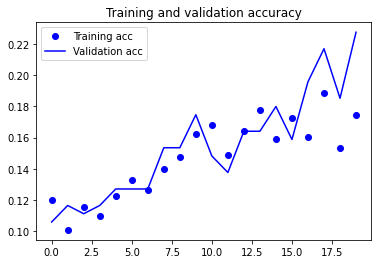

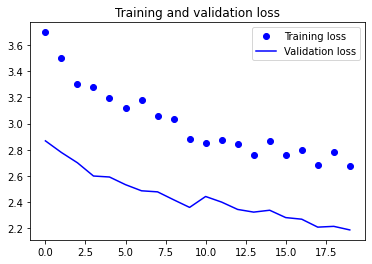

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Fine tuning last several layers.

In [ ]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
90/90 [==============================] - 103s 1s/step - loss: 2.6303 - acc: 0.1908 - val_loss: 2.1984 - val_acc: 0.2434
Epoch 2/20
90/90 [==============================] - 91s 990ms/step - loss: 2.6113 - acc: 0.1970 - val_loss: 2.1370 - val_acc: 0.2381
Epoch 3/20
90/90 [==============================] - 95s 1s/step - loss: 2.6435 - acc: 0.2037 - val_loss: 2.1311 - val_acc: 0.2328
Epoch 4/20
90/90 [==============================] - 92s 993ms/step - loss: 2.6632 - acc: 0.1998 - val_loss: 2.1249 - val_acc: 0.2169
Epoch 5/20
90/90 [==============================] - 96s 1s/step - loss: 2.5555 - acc: 0.1936 - val_loss: 2.1139 - val_acc: 0.2646
Epoch 6/20
90/90 [==============================] - 92s 1s/step - loss: 2.5548 - acc: 0.2026 - val_loss: 2.1755 - val_acc: 0.2487
Epoch 7/20
90/90 [==============================] - 93s 1s/step - loss: 2.5532 - acc: 0.2065 - val_loss: 2.1180 - val_acc: 0.2487
Epoch 8/20
90/90 [==============================] - 95s 1s/step - loss: 2.5134 - ac

In [ ]:
os.makedirs("./models", exist_ok=True)
model.save('./models/Panoramic.h5')

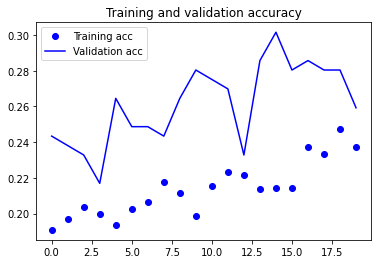

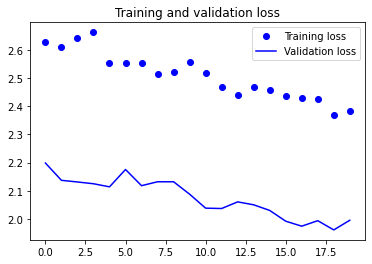

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Test predict 


In [ ]:
from tensorflow.keras.preprocessing import image
import pandas as pd

In [ ]:
clases =['Y7','Y8','Y9','Y10','Y11','Y12','Y13','Y16','Y17','Y18']
results = list()

for i in clases:
    img_path =val[val['Class']==i]['Path_filename'].tolist()
    for j in img_path:
        img = image.load_img(j, target_size=(height, width))
            # Convert it to a Numpy array with target shape.
        x = image.img_to_array(img)
            # Reshape
        x = x.reshape((1,) + x.shape)
        x /= 255.
        result = model.predict([x])[0]
        n = 10
        avgDists = result
        idxs = avgDists.argsort()[::-1][:n] #sort max
        predlist,problist = list(), list()
        for m in idxs:
            pred =  clases[m]
            prob = result[m]
            predlist.append(pred)
            problist.append(prob)
        act_true = i
        prob_max = problist[0]
        pred_max = predlist[0]

In [ ]:
result 

array([0.03075012, 0.04729026, 0.09616293, 0.075611  , 0.0437779 ,
       0.52738667, 0.1715209 , 0.00495058, 0.00103077, 0.00151882],
      dtype=float32)

In [ ]:
print(pred_max,prob_max)

Y12 0.52738667


In [ ]:
#res = predict_image()

In [ ]:
#path = 
#class_actual =['Y7','Y8','Y9','Y10','Y11','Y12','Y13','Y16','Y17','Y18']
#class_predict =[]
#for p in range(len(path)):
   # path_ = path[p]
    #class_actual.append(class_[p])
    #res = predict_image(path_)

    #predict_prop = max(res)
    #predict_class = class_[np.argmax(res)]

    #class_predict.append(predict_class)

In [ ]:
#from sklearn.metrics import confusion_matrix
 
#cm = confusion_matrix(class_actual,class_predict)
#cm

In [ ]:
#from sklearn.metrics import classification_report

#target_names = ['8Years', '9Years', '10Years']
#print(classification_report(class_actual, class_predict, target_names=target_names))

#Download the model


In [ ]:
#from google.colab import files

#files.download('./models/Paranoma_Fil,.h5')

In [ ]:
#model.input_shape